In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from lib.data.utils import train_data, targets, features, split_dataframe
from lib.data.plot import plot_predictions
from lib.models.estimators import PollutionEstimator
from lib.models.on_the_fly import OnTheFlyLSTM


import tensorflow as tf
import keras
from keras.callbacks import TensorBoard as TB, EarlyStopping as ES
from keras.regularizers import l1
import keras_tuner as kt
import seaborn as sns
sns.set_theme("notebook", style="whitegrid", rc={"figure.dpi": 100})
import pandas as pd

data_dir = "../data/"

df = train_data(data_dir, delta=False)

train_df, valid_df = split_dataframe(df, 0.2, 0.0)

full_train_df = pd.concat(train_df)
# for i in range(2):
#     train_df[i].loc[:, targets] = (train_df[i][targets] - full_train_df[targets].mean()) / full_train_df[targets].std()
# valid_df.loc[:, targets] = (valid_df[targets] - full_train_df[targets].mean()) / full_train_df[targets].std()
(X_train, X_valid), (y_train, y_valid) = ([td[features] for td in train_df], valid_df[features]), ([
    td[targets] for td in train_df], valid_df[targets])

def model_builder(hp):
    double_rnn = hp.Boolean("double_rnn")
    n_recursive_units = hp.Choice("n_recursive_units", values=[8, 64, 256])
    rnn_kernel_l1 = hp.Float("kernel_regularizer", min_value=1e-2, max_value=1e3, sampling="log")
    if double_rnn:
        second_layer = [n_recursive_units]
    else:
        second_layer = []
    model = OnTheFlyLSTM(len(features), len(targets), n_recursive_units=(
        [n_recursive_units] + second_layer), input_days=5, rnn_kwargs={"kernel_regularizer": l1(rnn_kernel_l1), "recurrent_regularizer": "l1"}, dense_kwargs={"kernel_regularizer": "l1"})
    estimator = PollutionEstimator(features, targets, model)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    estimator.adapt_training(train_df)
    estimator.compile(optimizer=keras.optimizers.deserialize(
        {"class_name": "adam", "config": {"learning_rate": lr}}), loss="mse")
    return estimator


In [10]:
model = OnTheFlyLSTM(len(features), len(targets), n_recursive_units=32, input_days=5)
estimator = PollutionEstimator(features, targets, model)
estimator.adapt_training(train_df)
estimator.compile(loss="mae", optimizer="adam", metrics=["mse", "mae"])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [ ]:

estimator.train(train_df, epochs=100, shift_hours=1, validation_data=valid_df, callbacks=[ES(patience=20, restore_best_weights=True)])

1/1 [==============================] - 0s 231ms/step


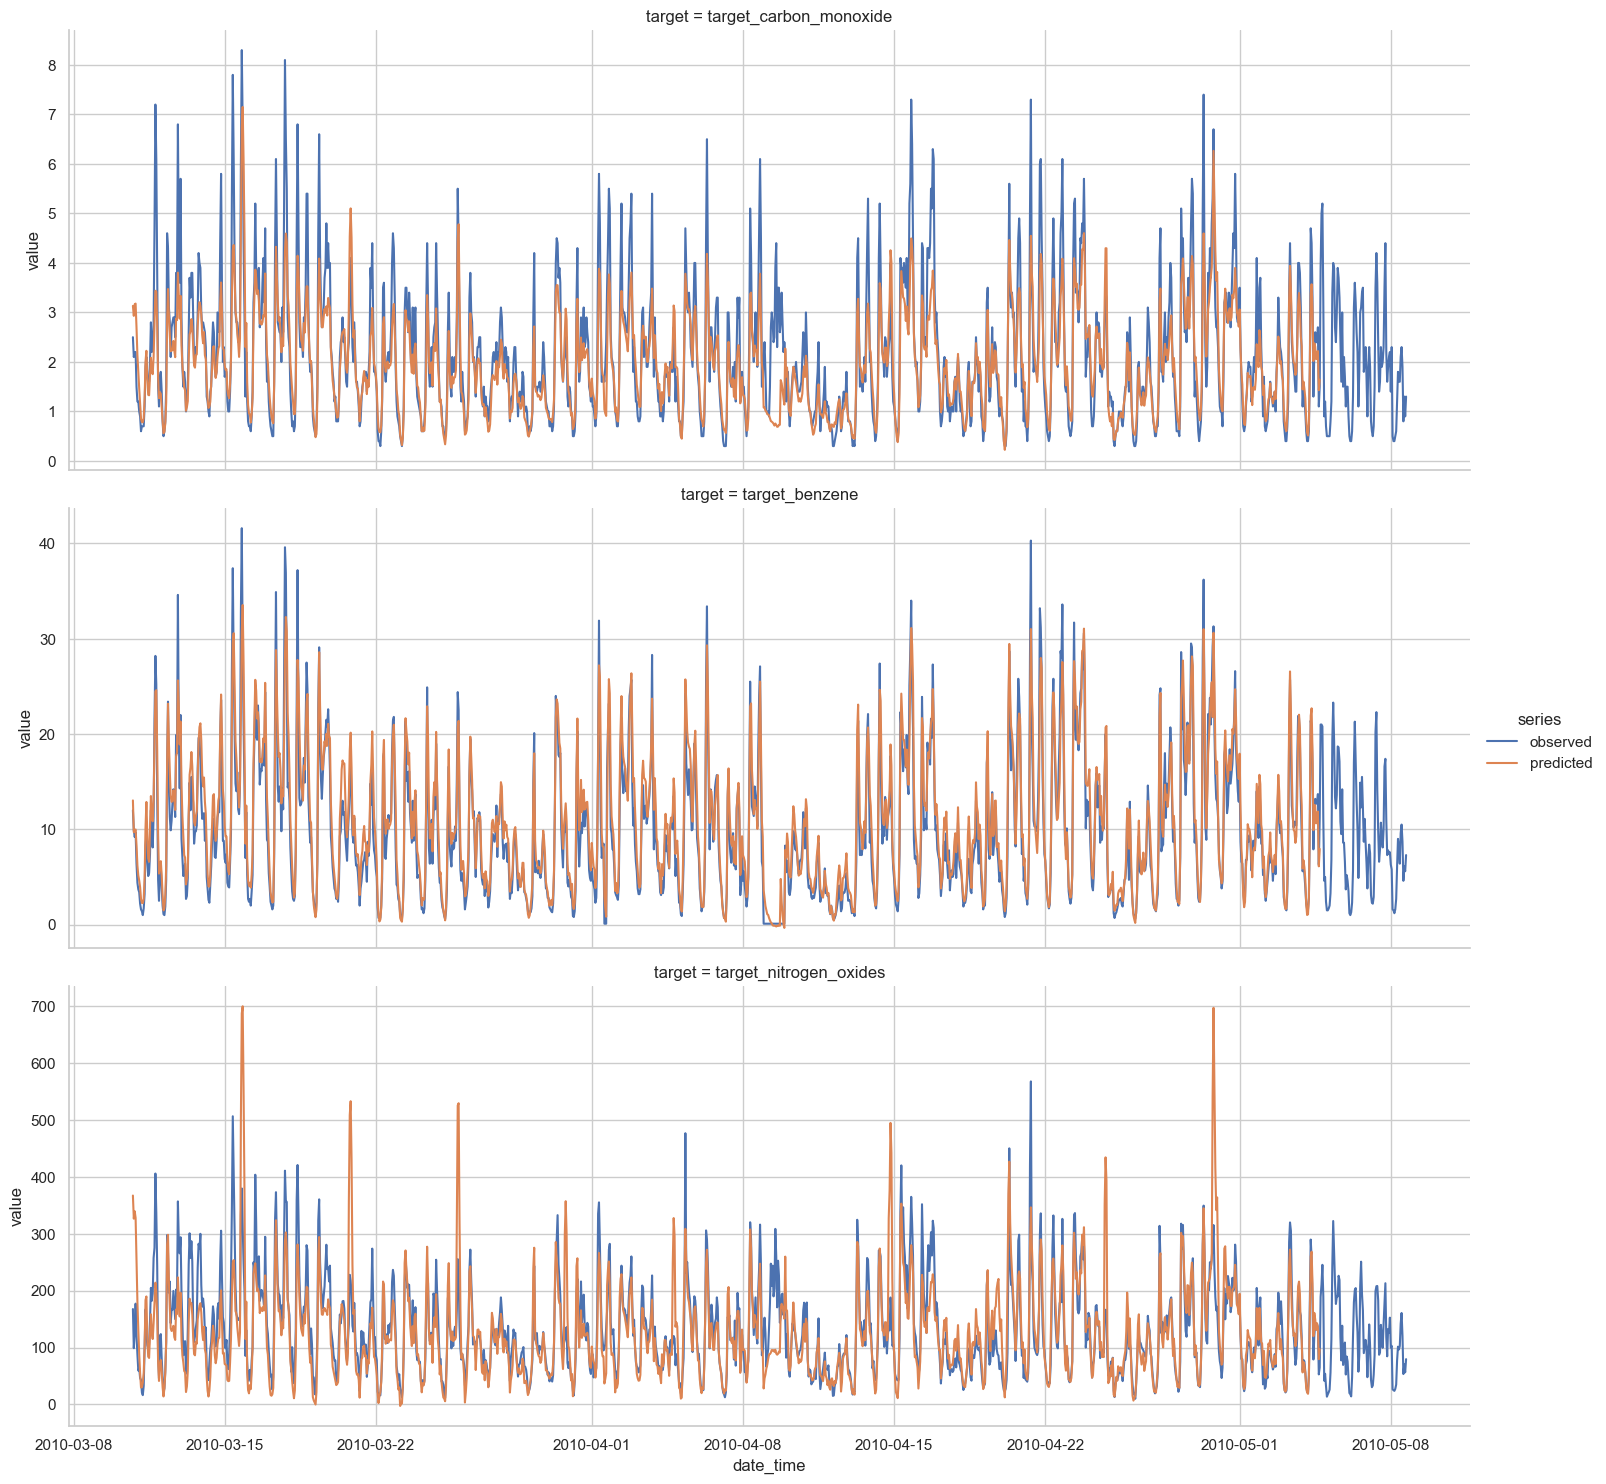

In [8]:
plot_predictions(valid_df, estimator, aspect=3, facet_kws={"sharey": False})

In [10]:
estimator.assess(valid_df, "mse")

1/1 [==============================] - 0s 81ms/step - loss: 11.5618


{'loss': 11.561758995056152}

In [6]:
tuner = kt.RandomSearch(model_builder, objective="val_loss", max_trials=1000, directory="tuning", project_name="kernel_regularization")
tuner.search(X_train, y_train, validation_data=valid_df, shift_hours=1, epochs=300, batch_size=128, callbacks=[ES(patience=20)], cache_to_disk=True)

Trial 98 Complete [00h 01m 47s]
val_loss: 1047.3822021484375

Best val_loss So Far: 684.2872924804688
Total elapsed time: 04h 57m 58s

Search: Running Trial #99

Value             |Best Value So Far |Hyperparameter
False             |True              |double_rnn
8                 |8                 |n_recursive_units
240.03            |0.1579            |kernel_regularizer
0.00027755        |0.0083579         |learning_rate

Epoch 1/300
44/44 [==============================] - 12s 187ms/step - loss: 23984.5078 - val_loss: 12836.9209
Epoch 2/300
44/44 [==============================] - 2s 35ms/step - loss: 21583.3203 - val_loss: 12762.7754
Epoch 3/300
44/44 [==============================] - 1s 31ms/step - loss: 19614.1719 - val_loss: 12688.7021
Epoch 4/300
44/44 [==============================] - 1s 29ms/step - loss: 18015.4121 - val_loss: 12579.9658
Epoch 5/300
44/44 [==============================] - 1s 29ms/step - loss: 16724.9570 - val_loss: 12318.7852
Epoch 6/300
44/44 [=========

KeyboardInterrupt: 

In [2]:
tuner = kt.Hyperband(model_builder, objective="val_loss", max_epochs=300, factor=5,
                        directory="tuning", project_name="on_the_fly_lstm_2", executions_per_trial=2)
tuner.search(X=X_train, y=y_train, validation_data=valid_df, shift_hours=1, batch_size=128, callbacks=[ES(patience=70)])


Trial 266 Complete [00h 05m 59s]
val_loss: 0.10453946143388748

Best val_loss So Far: 0.04966453090310097
Total elapsed time: 01h 07m 37s
INFO:tensorflow:Oracle triggered exit


In [7]:
tuner.results_summary() 

Results summary
Results in tuning/kernel_regularization
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0040 summary
Hyperparameters:
double_rnn: True
n_recursive_units: 8
kernel_regularizer: 0.15790323350403498
learning_rate: 0.008357947570368458
Score: 684.2872924804688

Trial 0069 summary
Hyperparameters:
double_rnn: True
n_recursive_units: 256
kernel_regularizer: 0.06354932390600397
learning_rate: 0.0008531941855305934
Score: 712.410888671875

Trial 0035 summary
Hyperparameters:
double_rnn: True
n_recursive_units: 8
kernel_regularizer: 0.03322238412864381
learning_rate: 0.0008878294112491289
Score: 736.3446655273438

Trial 0005 summary
Hyperparameters:
double_rnn: True
n_recursive_units: 256
kernel_regularizer: 0.0719782400873293
learning_rate: 0.0037607167682912265
Score: 752.6611328125

Trial 0068 summary
Hyperparameters:
double_rnn: True
n_recursive_units: 8
kernel_regularizer: 0.13195443599435558
learning_rate: 0.0005292195440206708
Score: 802.60083007

In [3]:
import json
import os
path = "tuning/random_search"
results = {}
for dir in os.listdir(path):
    if dir.startswith("trial"):
        with open(os.path.join(path, dir, "trial.json")) as f:
            result = json.load(f)
        id = result["trial_id"]
        results[id] = {"score": result["score"]}
        for key, value in result["hyperparameters"]["values"].items():
            results[id][key] = value

In [4]:
results_df = pd.DataFrame.from_dict(results, orient="index").astype({"learning_algorithm": "category", "double_rnn": "category"})

In [5]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0094 to 0229
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   score               333 non-null    float64 
 1   double_rnn          334 non-null    category
 2   input_days          334 non-null    int64   
 3   n_recursive_units   334 non-null    int64   
 4   learning_rate       334 non-null    float64 
 5   learning_algorithm  334 non-null    category
dtypes: category(2), float64(2), int64(2)
memory usage: 13.9+ KB


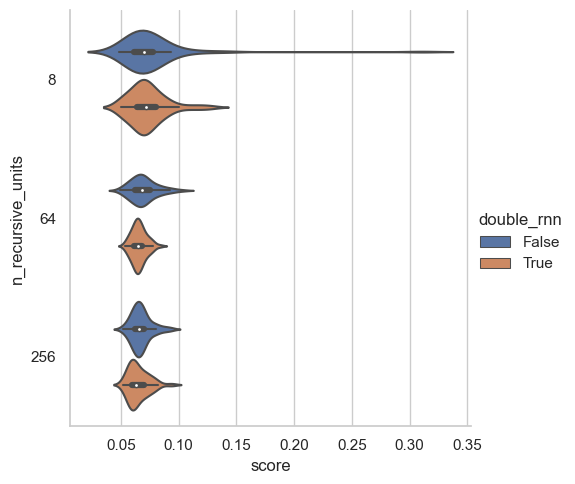

In [8]:
sns.catplot(data=results_df, x="score", y="n_recursive_units", hue="double_rnn", orient="h", kind="violin")

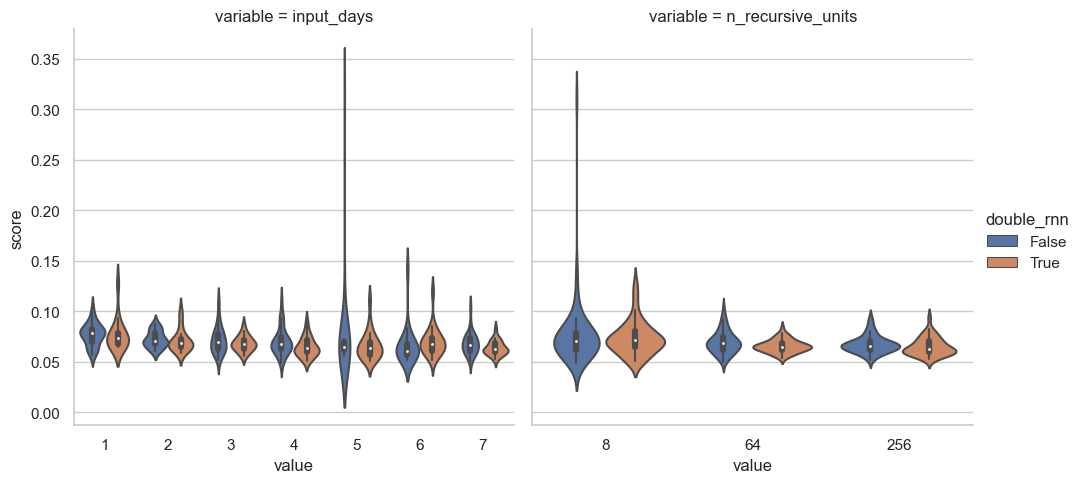

In [22]:
sns.catplot(data=results_df[["score", "input_days", "n_recursive_units", "double_rnn"]].melt(id_vars=["score", "double_rnn"]), x="value", y="score", col="variable", hue="double_rnn", kind="violin", sharex=False)

In [4]:
n_units = [64]
itd = [4]
models = [OnTheFlyLSTM(len(features), len(targets), n_recursive_units=[nu, 3], rnn_kwargs={}, input_days=d, name=f"n{nu}/id{d}") for nu in n_units for d in itd]
estimators = [PollutionEstimator(features, targets, model, name=model.name) for model in models]
for e in estimators:
    name = f"otf_dblrnn_regul_delta/adam/{e.name}"
    e.adapt_training(train_df)
    e.compile(optimizer=keras.optimizers.deserialize(
        {"class_name": "adam", "config": {"learning_rate": 0.005}}), loss="mse")
    e.train(train_df, epochs=2000, validation_data=valid_df, shift_hours=1, batch_size=128, callbacks=[
        TB(f"../logs/{name}"), ES(patience=100, restore_best_weights=True)])

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

1/1 [==============================] - 1s 777ms/step


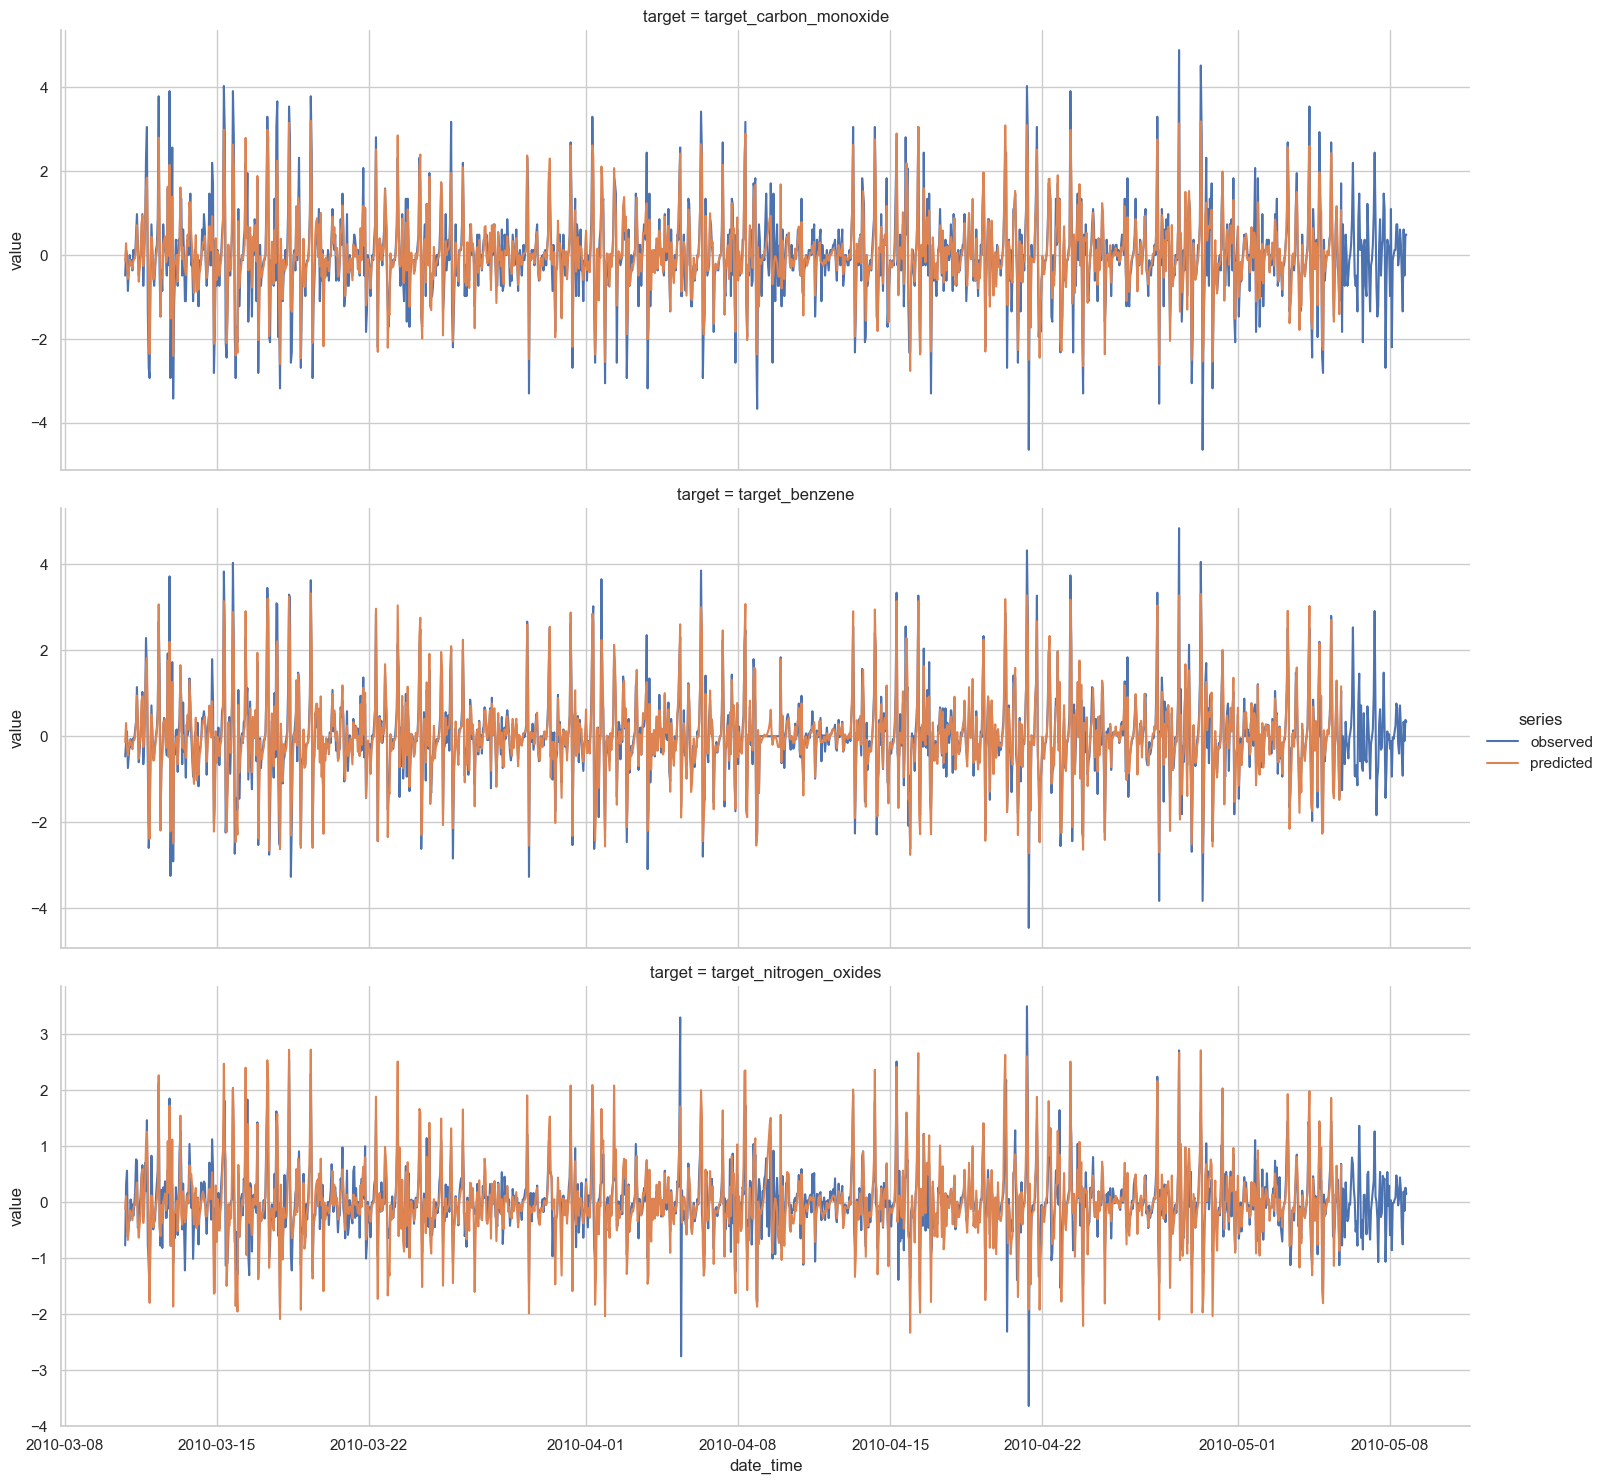

In [10]:
fg = plot_predictions(valid_df, estimators[0], aspect=3, facet_kws={
                      "sharey": False})  # , "xlim": (pd.Timestamp("2010-12-15"), pd.Timestamp("2010-12-25"))})


In [29]:
estimators[0].assess(valid_df, "mse")


1/1 [==============================] - 0s 50ms/step - loss: 807.6882


KeyError: 'mse'

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(train_df[features], train_df[targets])
